Import packages 

In [2]:
from Bio import SeqIO
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

Read Alignment Hit Table CSV, Rename Columns, Put data back in first row, View first five rows

In [5]:
align_hit = pd.read_csv('sars_coronavirus_accession/MN997409.1-4NY0T82X016-Alignment-HitTable.csv')
ah = align_hit
ah.columns = pd.MultiIndex.from_tuples(zip(["query acc.ver", "subject acc.ver", "% identity", "alignment length", 
                                            "mismatches", "gap opens", "q. start", "q. end", "s. start", "s. end",
                                            "evalue", "bit score"]))
ah.head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score
0,MN997409.1,MT020881.1,99.990,29882,3,0,1,29882,1,29882,0,55166
1,MN997409.1,MT020880.1,99.990,29882,3,0,1,29882,1,29882,0,55166
2,MN997409.1,MN985325.1,99.990,29882,3,0,1,29882,1,29882,0,55166
3,MN997409.1,MN975262.1,99.990,29882,3,0,1,29882,1,29882,0,55166
4,MN997409.1,LC522974.1,99.993,29878,2,0,4,29881,1,29878,0,55164


Describe Data

In [6]:
ah.describe().round(3)

,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score
count,262.000,262.000,262.000,262.000,262.000,262.000,262.000,262.000,262.0,262.000
mean,86.012,10637.943,922.744,58.042,11338.794,21940.321,11255.439,21858.328,0.0,14084.084
std,7.575,10483.913,1086.368,60.665,12024.681,10661.274,11966.473,10628.475,0.0,19095.454
min,77.559,1603.000,0.000,0.000,1.000,1923.000,1.000,1672.000,0.0,1011.000
25%,80.046,1925.000,142.000,12.000,16.000,21577.000,1.250,21489.000,0.0,2100.500
50%,82.304,5417.000,359.000,35.000,3956.000,27910.000,3878.500,27783.000,0.0,3936.000
75%,90.189,17716.000,989.000,68.000,22539.000,29874.750,22429.000,29729.000,0.0,15175.000
max,100.000,29882.000,2952.000,172.000,28257.000,29882.000,28137.000,30256.000,0.0,55166.000


Correlate Genomes

In [7]:
ah.corr().round(3).fillna(0)

,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score
% identity,1.000,0.627,-0.451,-0.533,-0.046,0.566,-0.046,0.569,0.0,0.790
alignment length,0.627,1.000,0.214,0.145,-0.559,0.353,-0.559,0.357,0.0,0.944
mismatches,-0.451,0.214,1.000,0.988,-0.201,-0.019,-0.203,-0.020,0.0,-0.120
gap opens,-0.533,0.145,0.988,1.000,-0.187,-0.072,-0.189,-0.073,0.0,-0.187
q. start,-0.046,-0.559,-0.201,-0.187,1.000,0.579,1.000,0.575,0.0,-0.500
q. end,0.566,0.353,-0.019,-0.072,0.579,1.000,0.579,1.000,0.0,0.365
s. start,-0.046,-0.559,-0.203,-0.189,1.000,0.579,1.000,0.575,0.0,-0.500
s. end,0.569,0.357,-0.020,-0.073,0.575,1.000,0.575,1.000,0.0,0.369
evalue,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000
bit score,0.790,0.944,-0.120,-0.187,-0.500,0.365,-0.500,0.369,0.0,1.000


Convert comparison genome accessions to codes

In [115]:
sc=ah.iloc[:,1]
ah.iloc[:,1] = ah.iloc[:,1].astype('category').cat.codes
print(sc)
print(ah.iloc[:,1])

0      MT020881.1
1      MT020880.1
2      MN985325.1
3      MN975262.1
4      LC522974.1
          ...    
257    AY283796.1
258    AY282752.2
259    AY282752.2
260    AY282752.2
261    AY282752.2
Name: (subject acc.ver,), Length: 262, dtype: object
0      85
1      84
2      66
3      65
4      55
       ..
257     3
258     2
259     2
260     2
261     2
Name: (subject acc.ver,), Length: 262, dtype: int8


standardize features by removing mean and scaling to unit variance

In [127]:
X = ah.iloc[:,1:].values
standardized_data = StandardScaler().fit_transform(X)
print(X)
print(standardized_data)

ValueError: could not convert string to float: 'MT020881.1'

Principal Component Analysis (PCA): dimension reduction of high dimensional data to visualize specific classes of genomes

In [117]:
covar_matrix = np.matmul(standardized_data.T , standardized_data)
values, vectors = eigh(covar_matrix, eigvals=(9,10))
vectors = vectors.T
vectors

array([[-0.08738973,  0.09708819, -0.22682186, -0.19480801, -0.19524037,
         0.52627599,  0.37097433,  0.52640775,  0.36952889,  0.        ,
        -0.16484755],
       [-0.40226981, -0.46050132, -0.41068552,  0.14648433,  0.18435451,
         0.10825881, -0.28237796,  0.10785356, -0.28427745,  0.        ,
        -0.46701965]])

In [118]:
new_coordinates = np.matmul(vectors, standardized_data.T)
new_coordinates = np.vstack((new_coordinates)).T
new_coordinates

array([[-0.85345579, -4.35438249],
       [-0.84989616, -4.33799691],
       [-0.78582283, -4.04305646],
       [-0.7822632 , -4.02667088],
       [-0.74638736, -3.8627661 ],
       [-0.88921838, -4.51777346],
       [-0.83938356, -4.28837533],
       [-0.81090653, -4.15729068],
       [-0.89989727, -4.5669302 ],
       [-0.77531023, -3.99343487],
       [-0.75011328, -3.87868684],
       [-0.74299402, -3.84591568],
       [-0.79306039, -4.0752387 ],
       [-0.78950076, -4.05885312],
       [-0.84313097, -4.30425966],
       [-0.83601172, -4.2714885 ],
       [-0.89282274, -4.53341414],
       [-0.86465504, -4.4021083 ],
       [-0.80414134, -4.12355343],
       [-0.88261948, -4.48357136],
       [-0.86126171, -4.38525788],
       [-0.85770208, -4.36887229],
       [-0.82922504, -4.23778765],
       [-0.800748  , -4.106703  ],
       [-0.7527904 , -3.89413267],
       [-0.79784713, -4.08927855],
       [-0.8758716 , -4.44988311],
       [-0.87488379, -4.43109554],
       [-0.74030883,

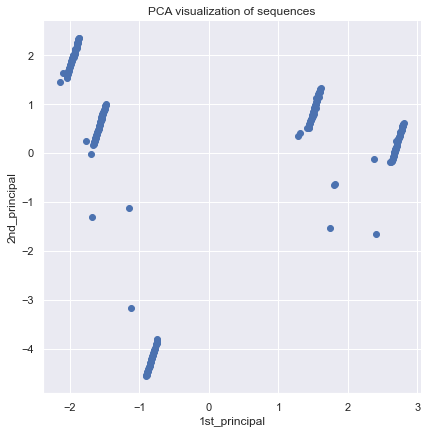

In [119]:
df = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal"))
sns.set()
sns.FacetGrid(df, height=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.title('PCA visualization of sequences')
plt.show()

Converting whole genomes to alignment sequences

In [120]:
# fasta to list
def fastalist(fastafile):
    fasta_seq = SeqIO.parse(str(fastafile),'fasta')
    fname = []
    fseq = []
    for i in fasta_seq:
        name, seq = i.id, str(i.seq)
        fname.append(name)
        fseq.append(seq)
    listt = (fname, fseq)
    return (listt)

In [121]:
# list to aligned dataframe
def alignlist(fasta_list, index, start, stop):
    df = pd.DataFrame({'acc': fasta_list[0], 'seq': fasta_list[1]})
    acc_name = df.iloc[index,0]
    seq = str(df.iloc[index,1])
    alist = seq[start:stop]
    # blist = [i for i in alist]
    newname = str(acc_name + "_align")
    adf = pd.DataFrame({'acc_name': newname, 'align_seq': alist}, index=[0])
    return (adf)

In [122]:
align_hit = pd.read_csv('sars_coronavirus_accession/MN997409.1-4NY0T82X016-Alignment-HitTable.csv')
ah = align_hit
dframe = pd.DataFrame(ah)
dframe = dframe.sort_values('MN997409.1.1', ascending=False)
dframe

,MN997409.1,MN997409.1.1,100,29882,0,0.1,1,29882.1,1.1,29882.2,0.2,55182
8,MN997409.1,NC_045512.2,99.987,29882,4,0,1,29882,1,29882,0,55160
29,MN997409.1,MT066176.1,99.980,29870,6,0,1,29870,1,29870,0,55127
16,MN997409.1,MT066175.1,99.993,29870,2,0,1,29870,1,29870,0,55149
5,MN997409.1,MT049951.1,99.987,29882,4,0,1,29882,1,29882,0,55160
41,MN997409.1,MT044258.1,99.906,29882,4,2,1,29882,1,29858,0,55005
...,...,...,...,...,...,...,...,...,...,...,...,...
90,MN997409.1,AY278554.2,79.305,1928,358,35,16,1923,1,1907,0,1312
192,MN997409.1,AP006561.1,90.117,1629,142,12,28257,29870,28103,29727,0,2098
190,MN997409.1,AP006561.1,82.304,17716,2948,169,3956,21577,3883,21505,0,15175
191,MN997409.1,AP006561.1,80.081,5417,987,68,22539,27910,22429,27798,0,3941


In [123]:
list1 = fastalist('sequences_40_BLAST_Kaggle_Accession.fasta')
alilist0 = alignlist(list1, 0, 0, 29882)
alilist0

acc_name  \
0  NC_045512_align   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [124]:
alilist1 = alignlist(list1, 1, 0, 29882)
alilist1

acc_name  \
0  MT066175_align   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              